# gluonts12-end_dates (yearly, deepar)

This notebook is used to check the performance of `deepar` on the yearly subsets of the m4 data with the same end dates. 

In [1]:
!pip install mxnet=="1.4.1"

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install gluonts

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import gluonts
print(gluonts.__version__)

import mxnet
print(mxnet.__version__)

# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar

0.4.2
1.4.1


INFO:root:Using CPU


In [2]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_end032014', 'm4_monthly_end052015', 'm4_monthly_end092007', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_end2003q3', 'm4_quarterly_end2013q1', 'm4_quarterly_end2015q1', 'm4_quarterly_finance', 'm4_quarterly_id

## Check datasets

In [5]:
dataname = "m4_weekly"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly.


**To do:** Transfer the quarterly datasets to the right place: 

- `mv [data] ../../.mxnet/gluon-ts/datasets

In [3]:
dataname = "m4_yearly_end2009"
dataset = get_dataset(dataname, regenerate=False)
len(dataset.train) # 6029

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_end2009.


6029

In [16]:
dataname = "m4_yearly_end1991"
dataset = utils.get_dataset(dataname, regenerate=False)
len(dataset.train) # 3496

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_end1991.


3496

In [4]:
dataname = "m4_yearly_end2004"
dataset = utils.get_dataset(dataname, regenerate=False)
len(dataset.train) # 984

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_end2004.


984

In [5]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

# check length of the series
print("length train dataset", len(dataset.train))
print("length test dataset", len(dataset.train))


dict_keys(['start', 'item_id', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'item_id', 'target', 'feat_static_cat', 'source'])
length train dataset 984
length test dataset 984


In [6]:
train_entry

{'start': Timestamp('1750-01-31 00:00:00', freq='12M'),
 'item_id': 'Y93',
 'target': array([6299.2856, 6617.7515, 6646.9556, 6842.242 , 7000.5493, 7203.311 ,
        7294.1323, 7729.0674, 7524.5405, 7373.8843, 6889.815 , 6864.537 ,
        6739.244 , 6831.9272, 6880.068 , 6516.8657, 7248.7617, 7815.169 ,
        8591.859 , 8721.834 , 7833.4243, 7720.185 , 7989.667 , 8207.53  ,
        8696.773 , 8662.692 , 8507.0205, 8166.554 , 8199.917 , 8267.792 ,
        8477.086 , 8176.0806, 8494.96  , 8766.62  , 8753.1875, 8462.25  ,
        7992.9634, 8161.5757, 8084.239 , 8255.591 , 8234.398 , 8303.153 ,
        8173.5044, 8284.113 , 8290.9375, 8055.8843], dtype=float32),
 'feat_static_cat': array([1], dtype=int32),
 'source': SourceContext(source=Span(path=PosixPath('/home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_end2004/train/m4_yearly_end2004_train.json'), line=1), row=1)}

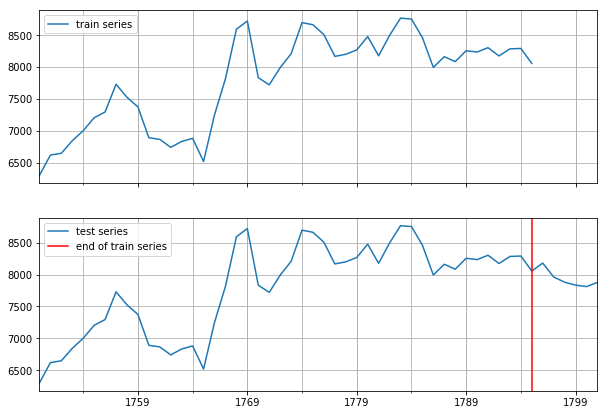

In [7]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [8]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [9]:
######################
### deepar wrapper ###
def deepar(data="m4_quarterly", seed=42, epochs=100, batches=50):

    dataset = get_dataset(data, regenerate=False)
    mx.random.seed(seed)
    np.random.seed(seed)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=batches,
        learning_rate=1e-3,
    )
    
    estimator = DeepAREstimator(
        trainer=trainer,
        cardinality= [
            feat_static_cat.cardinality 
            for feat_static_cat in dataset.metadata.feat_static_cat
        ],
        context_length=dataset.metadata.prediction_length,
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True
    )

    # predictor = estimator.train(training_data=dataset.train,
    #                             validation_data=dataset.test)
    predictor = estimator.train(training_data=dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = batches

    df = pd.DataFrame([output])

    return df

## Results

## Study 1: `m4_yearly_end2009`

In [ ]:
results = pd.DataFrame()

for i in range(45, 47):
    print("Seed:", i)
    df = deepar(data="m4_yearly_end2009", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_end2009.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]

Seed: 45


INFO:root:Number of parameters in DeepARTrainingNetwork: 331173
100%|██████████| 200/200 [00:12<00:00, 16.52it/s, avg_epoch_loss=7.69]
INFO:root:Epoch[0] Elapsed time 12.119 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.686536
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:12<00:00, 15.92it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[1] Elapsed time 12.581 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.216629
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:14<00:00, 13.93it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[2] Elapsed time 14.365 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.986696
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:14<00:00, 13.36it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[3] Elapsed time 14.985 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.751218
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:13<00:00, 14.70it/s, avg_epoch_

INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 200/200 [00:11<00:00, 17.61it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[37] Elapsed time 11.363 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.137842
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:11<00:00, 17.58it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[38] Elapsed time 11.384 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.183907
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:12<00:00, 15.60it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[39] Elapsed time 12.825 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.208514
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:13<00:00, 14.93it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[40] Elapsed time 13.413 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.131368
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:15<00:00, 13.01it/s, avg_epoch_loss=6.15

INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 200/200 [00:13<00:00, 14.35it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[74] Elapsed time 13.940 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.037411
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:12<00:00, 16.38it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[75] Elapsed time 12.214 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.040029
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:12<00:00, 15.49it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[76] Elapsed time 12.915 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.048542
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:16<00:00, 12.20it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[77] Elapsed time 16.393 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.088744
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:12<00:00, 15.44it/s, avg_epoch_loss=6.05

100%|██████████| 200/200 [00:13<00:00, 15.06it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[110] Elapsed time 13.283 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.980903
INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 200/200 [00:11<00:00, 16.76it/s, avg_epoch_loss=6]   
INFO:root:Epoch[111] Elapsed time 11.940 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.997077
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 200/200 [00:16<00:00, 12.32it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[112] Elapsed time 16.238 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.877362
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 200/200 [00:13<00:00, 14.98it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[113] Elapsed time 13.359 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.861081
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 200/200 [00:12<00:00, 16.15it/s, avg_epoch_loss=5.9] 
INFO:root:Epoch[114] Elap

100%|██████████| 200/200 [00:13<00:00, 14.63it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[146] Elapsed time 13.678 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.834350
INFO:root:Epoch[147] Learning rate is 0.00025
100%|██████████| 200/200 [00:13<00:00, 14.59it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[147] Elapsed time 13.708 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.785439
INFO:root:Loading parameters from best epoch (137)
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 200/200 [00:13<00:00, 14.75it/s, avg_epoch_loss=5.8] 
INFO:root:Epoch[148] Elapsed time 13.567 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.803827
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 200/200 [00:11<00:00, 17.04it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[149] Elapsed time 11.741 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.811825
INFO:root:Epoch[150] Learning rate is 0.000125
100%|██████████| 200/200 [00:13<00:00,

INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=5.824213
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 200/200 [00:12<00:00, 15.46it/s, avg_epoch_loss=5.8] 
INFO:root:Epoch[182] Elapsed time 12.941 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=5.802354
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:13<00:00, 14.76it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[183] Elapsed time 13.558 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.788441
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 13.22it/s, avg_epoch_loss=5.8] 
INFO:root:Epoch[184] Elapsed time 15.130 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.798858
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:13<00:00, 14.36it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[185] Elapsed time 13.938 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.759925
INFO:root:Epoch[186] Learning rate is 5

100%|██████████| 200/200 [00:13<00:00, 14.85it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[218] Elapsed time 13.469 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=5.794523
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 200/200 [00:12<00:00, 16.01it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[219] Elapsed time 12.496 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=5.721682
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:13<00:00, 14.64it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[220] Elapsed time 13.668 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=5.751545
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:11<00:00, 16.67it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[221] Elapsed time 12.001 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=5.775840
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 12.88it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[222] Elapsed 

INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=5.674115
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 200/200 [00:12<00:00, 15.47it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[255] Elapsed time 12.938 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=5.780268
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:14<00:00, 13.58it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[256] Elapsed time 14.731 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.718130
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:13<00:00, 15.14it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[257] Elapsed time 13.213 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=5.742403
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:12<00:00, 16.20it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[258] Elapsed time 12.353 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=5.837686
INFO:root:Epoch[259] Learning rate is 5

100%|██████████| 200/200 [00:17<00:00, 11.73it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[291] Elapsed time 17.061 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=5.796531
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 200/200 [00:14<00:00, 13.44it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[292] Elapsed time 14.880 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=5.771826
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:11<00:00, 17.17it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[293] Elapsed time 11.657 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=5.726556
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:10<00:00, 19.19it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[294] Elapsed time 10.427 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=5.756239
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:12<00:00, 16.65it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[295] Elapsed t

INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=5.733944
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 200/200 [00:09<00:00, 21.16it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[328] Elapsed time 9.457 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=5.730680
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 23.20it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[329] Elapsed time 8.636 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=5.714917
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 23.63it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[330] Elapsed time 8.468 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.730829
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:10<00:00, 19.79it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[331] Elapsed time 10.112 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.740683
INFO:root:Epoch[332] Learning rate is 5e-0

100%|██████████| 200/200 [00:07<00:00, 25.16it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[364] Elapsed time 7.954 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=5.658638
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 26.41it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[365] Elapsed time 7.594 seconds
INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=5.689504
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.68it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[366] Elapsed time 7.796 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.663141
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:09<00:00, 20.29it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[367] Elapsed time 9.862 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.708105
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 22.24it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[368] Elapsed time

Running evaluation: 100%|██████████| 6029/6029 [02:54<00:00, 34.57it/s]
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_end2009.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.095425  0.152526  55.864927            0.155634            0.105101   

   seed  epochs  num_batches  
0    45     400          200  
Seed: 46


INFO:root:Number of parameters in DeepARTrainingNetwork: 331173
100%|██████████| 200/200 [00:10<00:00, 19.48it/s, avg_epoch_loss=7.79]
INFO:root:Epoch[0] Elapsed time 10.285 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.789949
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:08<00:00, 22.68it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[1] Elapsed time 8.822 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.237618
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:09<00:00, 20.36it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[2] Elapsed time 9.829 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.048225
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:09<00:00, 20.73it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[3] Elapsed time 9.658 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.861737
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:09<00:00, 20.22it/s, avg_epoch_los

100%|██████████| 200/200 [00:08<00:00, 23.15it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[37] Elapsed time 8.646 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.183056
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:09<00:00, 21.70it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[38] Elapsed time 9.229 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.182388
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:09<00:00, 20.55it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[39] Elapsed time 9.741 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.222738
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:09<00:00, 20.41it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[40] Elapsed time 9.801 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.130748
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:08<00:00, 23.06it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[41] Elapsed time 8.678 second

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 200/200 [00:08<00:00, 23.30it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[74] Elapsed time 8.605 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.091758
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 200/200 [00:07<00:00, 28.01it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[75] Elapsed time 7.145 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.077613
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 42.33it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[76] Elapsed time 4.729 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.076878
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 43.21it/s, avg_epoch_loss=6]
INFO:root:Epoch[77] Elapsed time 4.635 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.996036
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 43.07it/s, avg_epoch_loss=6.02]


100%|██████████| 200/200 [00:05<00:00, 38.64it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[110] Elapsed time 5.181 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.969983
INFO:root:Loading parameters from best epoch (100)
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:05<00:00, 35.81it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[111] Elapsed time 5.591 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.986880
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:05<00:00, 38.40it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[112] Elapsed time 5.214 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.971236
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 41.95it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[113] Elapsed time 4.781 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.961112
INFO:root:Epoch[114] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 40

100%|██████████| 200/200 [00:05<00:00, 34.48it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[146] Elapsed time 5.804 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.948028
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 35.07it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[147] Elapsed time 5.709 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.882265
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.41it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[148] Elapsed time 4.959 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.945816
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.00it/s, avg_epoch_loss=5.92]
INFO:root:Epoch[149] Elapsed time 4.881 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.920341
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.66it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 37.71it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[183] Elapsed time 5.309 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.910004
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 34.58it/s, avg_epoch_loss=5.92]
INFO:root:Epoch[184] Elapsed time 5.791 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.920349
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 35.99it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[185] Elapsed time 5.560 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.893788
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 34.32it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[186] Elapsed time 5.836 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.971898
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 36.65it/s, avg_epoch_

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=5.935962
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 37.30it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[220] Elapsed time 5.370 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=5.940844
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 37.42it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[221] Elapsed time 5.352 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=5.953679
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 36.00it/s, avg_epoch_loss=5.92]
INFO:root:Epoch[222] Elapsed time 5.563 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=5.923913
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 36.27it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[223] Elapsed time 5.521 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=5.863790
INFO:root:Epoch[224] Learning rate is 5e-05

100%|██████████| 200/200 [00:05<00:00, 34.75it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[256] Elapsed time 5.760 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.867492
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 34.73it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[257] Elapsed time 5.761 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=5.901425
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.07it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[258] Elapsed time 5.127 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=5.858079
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 36.36it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[259] Elapsed time 5.505 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.902801
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.78it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[260] Elapsed time 4

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 36.30it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[293] Elapsed time 5.512 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=5.828741
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 34.78it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[294] Elapsed time 5.757 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=5.845487
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.48it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[295] Elapsed time 5.201 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.866651
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.08it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[296] Elapsed time 4.994 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=5.815241
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 36.56it/s, avg_epoch_

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=5.812372
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 34.87it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[330] Elapsed time 5.738 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.800470
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 34.12it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[331] Elapsed time 5.869 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.882644
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 35.52it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[332] Elapsed time 5.636 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=5.818147
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.27it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[333] Elapsed time 4.968 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=5.821356
INFO:root:Epoch[334] Learning rate is 5e-05


100%|██████████| 200/200 [00:05<00:00, 36.43it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[366] Elapsed time 5.502 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.798112
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 37.88it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[367] Elapsed time 5.288 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.871037
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.44it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[368] Elapsed time 4.954 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=5.873311
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 37.47it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[369] Elapsed time 5.343 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=5.902955
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.45it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[370] Elapsed time 5

## Study 2: `m4_yearly_end1991`

In [ ]:
# results = pd.DataFrame()

# for i in range(42, 52):
#     print("Seed:", i)
#     df = deepar(data="m4_yearly_end1991", seed=i, epochs=400, batches=200)
#     pprint(df)
#     results = results.append(df)

# results

## Study 3: `m4_yearly_end2004`

In [ ]:
results = pd.DataFrame()

for i in range(44, 47):
    print("Seed:", i)
    df = deepar(data="m4_yearly_end2004", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results